# Running model on the DataSet
 A whole-cell recording database of neuromodulatory action in the adult neocortex Xuan Yan, Niccolo Calcini, Payam Safavi, Asli Ak, Koen Kole, Fleur Zeldenrust, Tansu Celikel
bioRxiv 2022.01.12.476007; doi: https://doi.org/10.1101/2022.01.12.476007)

In [8]:
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *

In [9]:

path = "G:/My Drive/Analyzed/asli_1-18-7-19_E2_analyzed.mat"
data = loadmatInPy(path)

In [10]:
for i in data:
    print(i['input_generation_settings']['condition'])

ACSF
M1-ago
M1-ant


In [11]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

def return_partitioned_data(data,partitions,clean = True):
    input_settings = data['input_generation_settings']
    total_length = len(data['membrane_potential'])
    V = data['membrane_potential']
    I = data['input_current']
    h = data['hidden_state']
    thresholds = data['thresholds']
    if clean:
        idx = ~np.isnan(thresholds)
        thresholds = thresholds[idx]
        spks_acsf = data['spikeindices'][idx]
        threshold_idx = data['thresholdindices'][idx]
    else:
        # idx = ~np.isnan(thresholds)
        thresholds = thresholds
        spks_acsf = data['spikeindices']
        threshold_idx = data['thresholdindices']

    data_partitions = []

    for i in range(partitions):
        V_ = V[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        I_ = I[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        h_ = h[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        idx_temp = np.where((spks_acsf>=((total_length//partitions)*(i)))&(spks_acsf<((total_length//partitions)*(i+1))))
        spks_ = spks_acsf[idx_temp]-((i)*total_length//partitions)

        thresholds_ = thresholds[idx_temp]
        threshold_idx_ = threshold_idx[idx_temp]-((i)*total_length//partitions)

        data_idx = {'membrane_potential':V_,
                    'input_current':I_,
                    'hidden_state':h_,
                    'spikeindices':spks_,
                    'thresholds':thresholds_,
                    'thresholdindices':threshold_idx_,
                    'input_generation_settings':input_settings,
                    'firing_rate':len(spks_)*(input_settings['sampling_rate']*1000)/(total_length//partitions)
                    }
        data_partitions.append(data_idx)

    return data_partitions


In [12]:
part_data = return_partitioned_data(data[1],36000,clean=False)

In [13]:
time = 360*20000
h = data[1]['hidden_state'][:]
I = data[1]['input_current'][:]
spikes = data[1]['spikeindices'][:]
V = data[1]['membrane_potential'][:]


In [14]:
means = [np.mean(part_data[i]['input_current']) for i in range(len(part_data))]
means = means-np.mean(means)
vars = [np.var(part_data[i]['input_current']) for i in range(len(part_data))]
vars = vars-np.mean(vars)
frs = [part_data[i]['firing_rate'] for i in range(len(part_data))]
frs = frs-np.mean(frs)


In [15]:

ups = np.where(np.diff(np.array(h,dtype=np.int32))==1)
downs = np.where(np.diff(np.array(h,dtype=np.int32))==-1)
# (downs[0]- ups[0])/20
(downs[0]-ups[0][:-1])/20

array([ 35.75,  19.75,  64.9 , ...,  71.8 , 125.25,   9.7 ])

In [16]:
binary_spikes = np.zeros(len(V))
binary_spikes[spikes] =1

In [247]:
import numpy.random
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import scipy 

from elephant.kernels import ExponentialKernel,GaussianKernel
from elephant.statistics import time_histogram, instantaneous_rate
from quantities import ms, s, Hz
import quantities as pq
from neo.core import SpikeTrain
from quantities import s


def gaussian( x , sigma):
    return 1./np.sqrt( 2. * np.pi * sigma**2 ) * np.exp( -x**2 / ( 2. * sigma**2 ) )

def causal(x, alpha):
    return np.exp(alpha*x)

def exponential_kernel(x, tau):
  """
  Creates an exponential kernel with a decay constant.

  Args:
      t: Time values for the kernel (array-like).
      tau: Time shift for the kernel (float).
      decay_constant: Positive constant controlling the decay rate (default 1).

  Returns:
      A NumPy array representing the exponential kernel.
  """
  return scipy.stats.expon.pdf(x, loc=-10, scale=tau)
#convolution
def smooth_gaussian(y,box_pts): 
    x = (np.linspace(-box_pts/2.,box_pts/2.,box_pts + 1)) #Gaussian centred on 0
    std_norm = 2. #3. is an arbitrary value for normalizing the sigma
    sigma = box_pts/std_norm 
    integral = quad(gaussian, x[0], x[-1], args=(sigma))[0]
    box = gaussian(x, sigma)/integral

    y_smooth = np.convolve(y,box,mode='same')
    return y_smooth


def smooth_exp(spikes,tau): 

    train = SpikeTrain(spikes/20*ms, t_stop=360*1000,units=ms)
    inst_fr = instantaneous_rate(train, sampling_period=1/20*ms, kernel=ExponentialKernel(tau*ms))
    return np.hstack(inst_fr.__array__())


def smooth_gaussian_e(spikes,tau): 

    train = SpikeTrain(spikes/20*ms, t_stop=360*1000,units=ms)
    inst_fr = instantaneous_rate(train, sampling_period=1/20*ms, kernel=GaussianKernel(tau*ms))
    return np.hstack(inst_fr.__array__())


In [196]:
binary_spikes_nan = np.zeros(len(V))*np.nan
binary_spikes_nan[spikes] =1

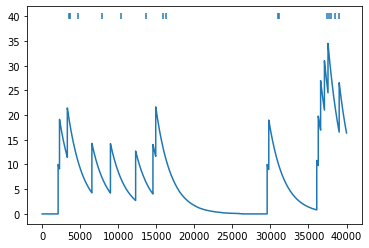

In [198]:
plt.scatter(np.arange(len(binary_spikes_nan[:20000*2])),binary_spikes_nan[:20000*2]*40,marker='|')
plt.plot(smooth_exp(spikes,100)[:20000*2])

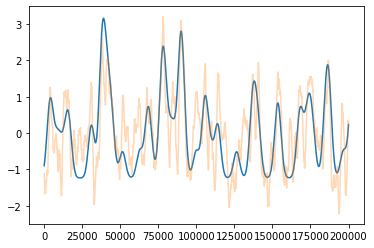

In [259]:
def standardize(data):
    return (data-np.mean(data))/np.std(data)

input_smooth = smooth_gaussian(I,100*20)
fr_gaussian = smooth_gaussian(binary_spikes,100*20)
plt.plot(standardize(inst_fr[:20000*10]))
plt.plot(standardize(input_smooth[:20000*10]),alpha=0.3)


In [248]:
tau = 100
train = SpikeTrain(spikes/20*ms, t_stop=360*1000,units=ms)
inst_fr = instantaneous_rate(train, sampling_period=1/20*ms, kernel=GaussianKernel(tau*ms))

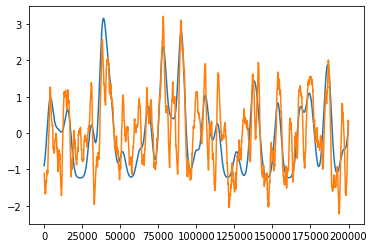

In [264]:
plt.plot(standardize(inst_fr[:20000*10]))
plt.plot(standardize(I_convs[2][:20000*10]))
# plt.plot(standardize(fr_gaussian[:20000*10]),alpha=0.2)


In [338]:
cust_time_winds =[10,50,np.arange(100,600,100)]
cust_time_winds = np.hstack(cust_time_winds)


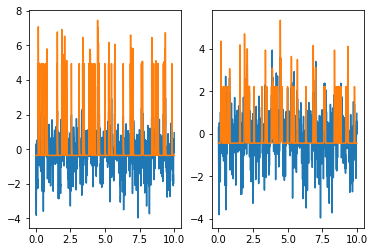

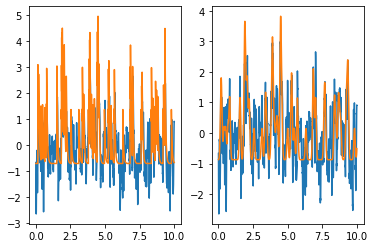

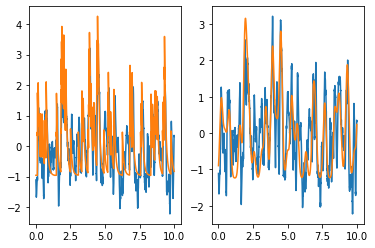

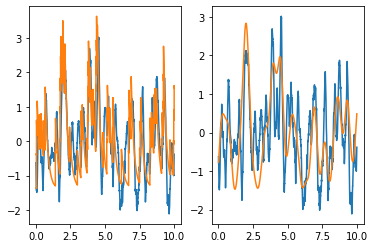

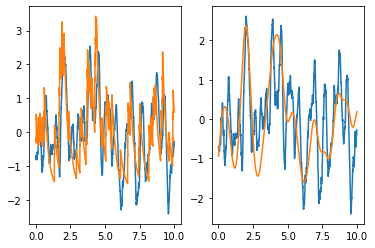

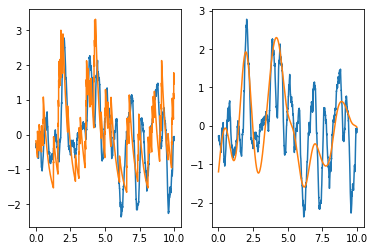

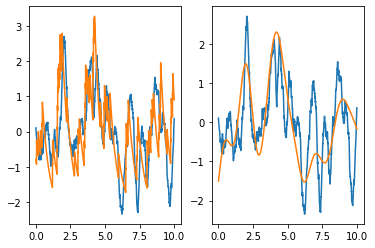

In [339]:
def standardize(data):
    return (data-np.mean(data))/np.std(data)
I_convs = []
fr_convs_exps = []
fr_convs_gaussian = []
h_convs = []
for i in cust_time_winds:
    fig,[ax1,ax2] = plt.subplots(1,2)
    box_size = i*20
    spikes_smooth = smooth_exp(spikes,i)
    spikes_smooth_g = smooth_gaussian_e(spikes,i)

    input_smooth = smooth_gaussian(I,box_size)
    h_smooth = smooth_gaussian(h,box_size)

    I_convs.append(input_smooth)
    fr_convs_exps.append(spikes_smooth)
    fr_convs_gaussian.append(spikes_smooth)
    h_convs.append(h_smooth)
    x = np.linspace(0,10,10*20000)
    ax1.plot(x,standardize(input_smooth[:10*20000]))
    ax1.plot(x,standardize(spikes_smooth[:10*20000]))
    ax2.plot(x,standardize(input_smooth[:10*20000]))
    ax2.plot(x,standardize(spikes_smooth_g[:10*20000]))    
    plt.show()


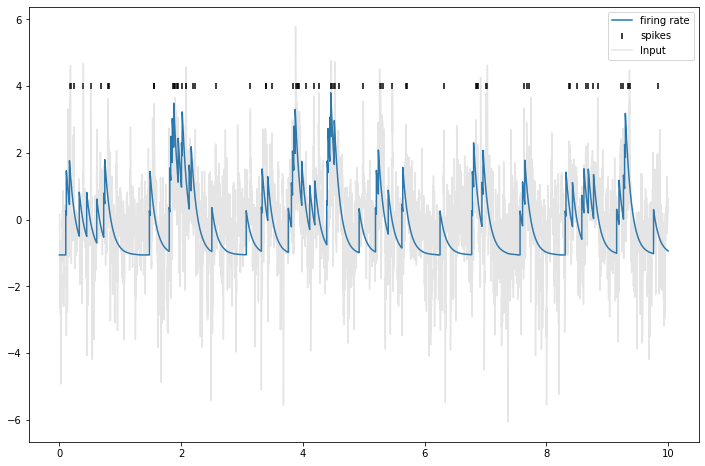

In [244]:
time = 10
x = np.linspace(0,10,10*20000)
plt.figure(figsize=[12,8])
plt.plot(x,(standardize(fr_convs[2]))[:time*20000])
plt.scatter(x, binary_spikes_nan[:time*20000]*4,c='black',marker="|")
plt.plot(x,(standardize(I))[:time*20000],c='grey',alpha=0.2)
plt.legend(['firing rate','spikes','Input'])
plt.show()

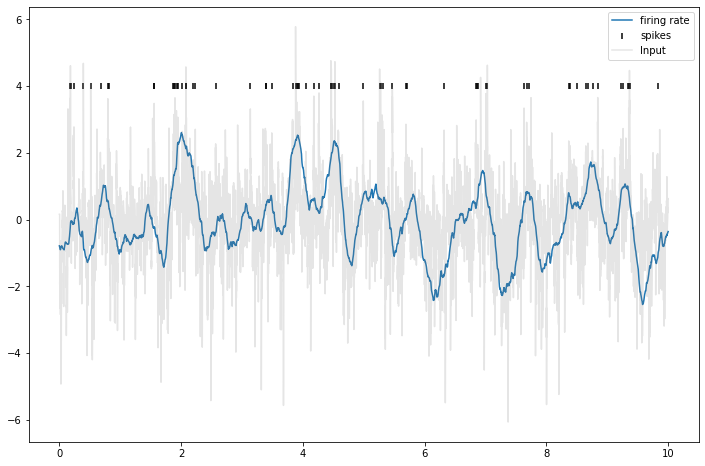

In [70]:
time = 10
x = np.linspace(0,10,10*20000)
plt.figure(figsize=[12,8])
plt.plot(x,(standardize(I_convs[2]))[:time*20000])
plt.scatter(x, binary_spikes_nan[:time*20000]*4,c='black',marker="|")
plt.plot(x,(standardize(I))[:time*20000],c='grey',alpha=0.2)
plt.legend(['firing rate','spikes','Input'])
plt.show()

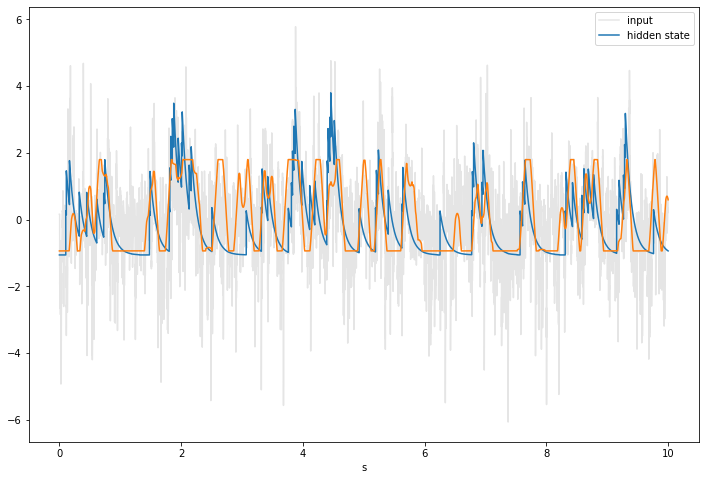

In [72]:
time = 10
x = np.linspace(0,10,10*20000)
plt.figure(figsize=[12,8])
plt.plot(x,standardize(I)[:time*20000],c='grey',alpha=0.2)
plt.plot(x,standardize(fr_convs[0])[:time*20000])
plt.plot(x,standardize(h_convs[0])[:time*20000])
plt.legend(['input','hidden state'],)
plt.xlabel('s')
plt.show()

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


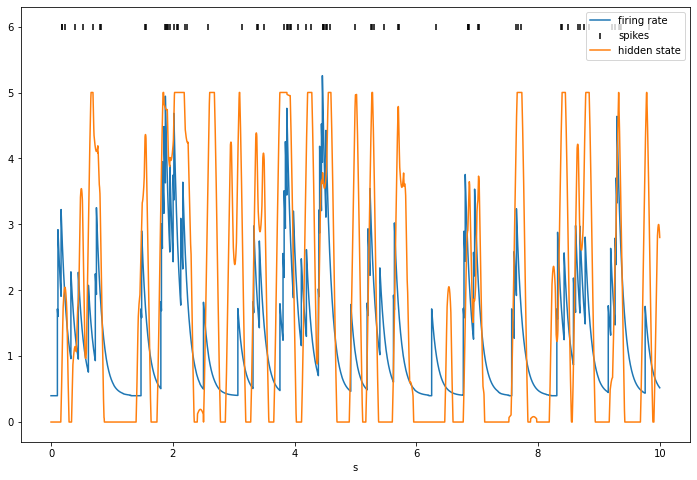

In [73]:
time = 10
x = np.linspace(0,10,10*20000)
plt.figure(figsize=[12,8])
plt.plot(x,standardize(fr_convs[0])[:time*20000]-min(standardize(fr_convs[1])[:time*20000]))
plt.scatter(x,binary_spikes_nan[:time*20000]*6,c='black',marker="|")
plt.plot(x,h_convs[0][:time*20000]*5)
plt.legend(['firing rate','spikes','hidden state'],)
plt.xlabel('s')
plt.show()

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


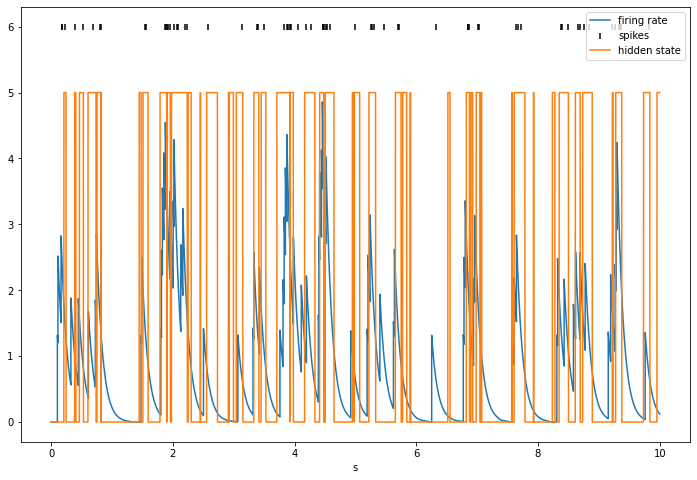

In [100]:
time = 10
x = np.linspace(0,time,time*20000)
plt.figure(figsize=[12,8])
plt.plot(x,standardize(fr_convs[0])[:time*20000]-min(standardize(fr_convs[0])[:time*20000]))
plt.scatter(x,binary_spikes_nan[:time*20000]*6,c='black',marker="|")
plt.plot(x,h[:time*20000]*5)
plt.legend(['firing rate','spikes','hidden state'],)
plt.xlabel('s')
plt.show()

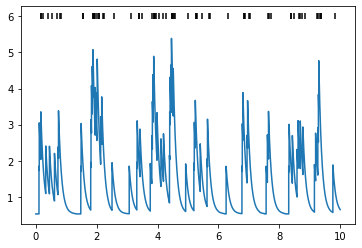

In [76]:
plt.plot(x,standardize(fr_convs[0])[:time*20000]-min(standardize(fr_convs[0])[:time*20000]))
plt.scatter(x,binary_spikes_nan[:time*20000]*6,c='black',marker="|")
plt.show()


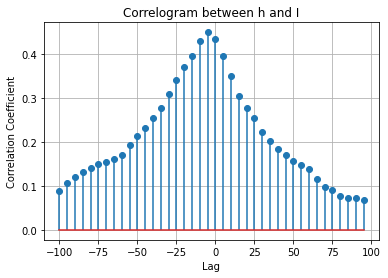

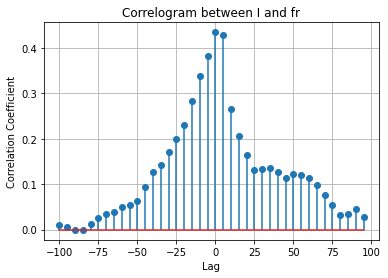

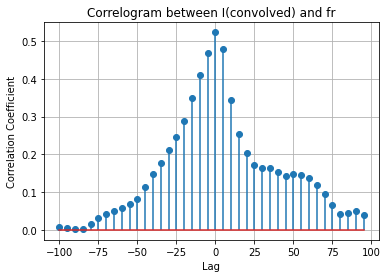

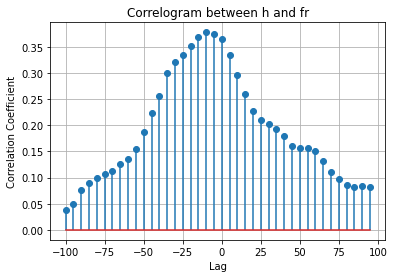

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Sample signals (replace with your actual data)
def plot_correlations(sig1,sig2,tau,str1,str2,ax):
    signal1 = sig1-np.mean(sig1)
    signal2 = sig2-np.mean(sig2)
    # Calculate cross-correlation with maximum lag of 20
    correlation = signal.correlate(signal1, signal2 , mode='full')
    correlation /= np.sqrt(np.sum(signal1**2)*np.sum(signal2**2))    
    lags = signal.correlation_lags(len(signal1), len(signal1))

    # Plot the correlogram
    # lags = np.arange(-tau,tau,1/20)
    # plt.stem(lags[::100], correlation[len(correlation)//2-tau*20:len(correlation)//2+tau*20][::100])
    ax.stem(lags[len(lags)//2-100*20:len(lags)//2+100*20:100]/20, correlation[len(lags)//2-100*20:len(lags)//2+100*20:100])

    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title(f'Correlogram between {str1} and {str2}')
    ax.grid(True)
    # plt.show()

# plot_correlations()
fig,ax = plt.subplots()
plot_correlations(h[:10*20000],I[:10*20000],100,'h','I',ax)
fig,ax = plt.subplots()
plot_correlations(I[:10*20000],np.hstack(fr_convs_exps[0][:10*20000]),100,'I','fr',ax)
fig,ax = plt.subplots()
plot_correlations(I_convs[0][:10*20000],np.hstack(fr_convs_exps[0][:10*20000]),100,'I(convolved)','fr',ax)
fig,ax = plt.subplots()
plot_correlations(h[:10*20000],np.hstack(fr_convs_exps[0][:10*20000]),100,'h','fr',ax)

# plot_correlations(h[:10*20000],I[:10*20000],100,'h','I')

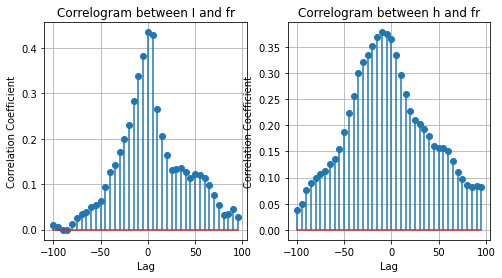

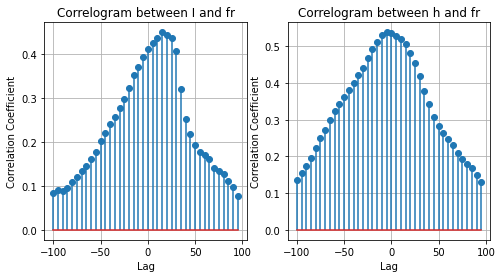

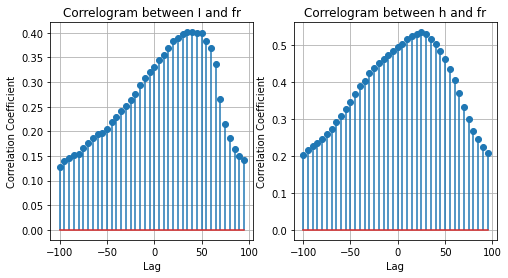

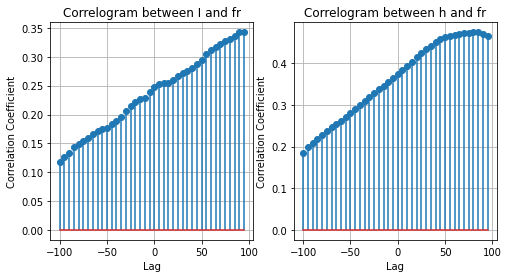

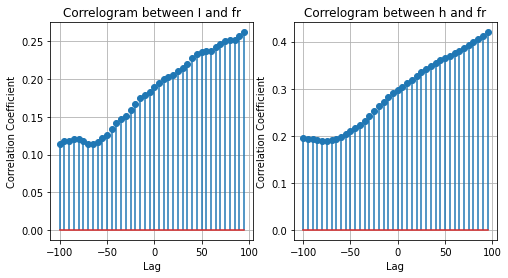

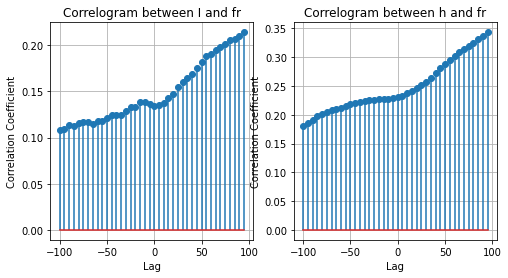

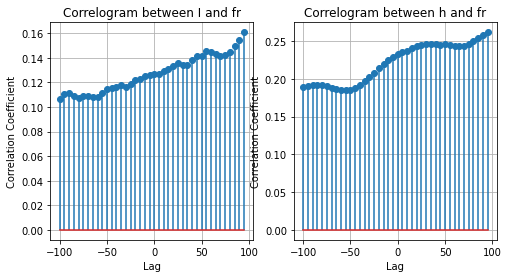

In [346]:

for i in range(len(fr_convs_exps)):
    fig,[ax1,ax2] = plt.subplots(1,2,figsize=[8,4])
    plot_correlations(I[:10*20000],np.hstack(fr_convs_exps[i][:10*20000]),100,'I','fr',ax1)
    # plot_correlations(I_convs[0][:10*20000],np.hstack(fr_convs_exps[0][:10*20000]),100,'I(convolved)','fr')
    plot_correlations(h[:10*20000],np.hstack(fr_convs_exps[i][:10*20000]),100,'h','fr',ax2)
    plt.show()

# reverse correlations

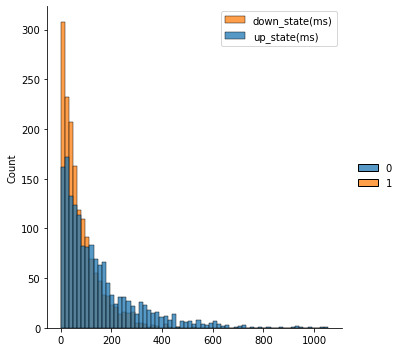

In [268]:
h = np.array(h,dtype=np.int32)
ups = np.where(np.diff(h)==1)[0]+1
downs = np.where(np.diff(h)==-1)[0]+1

sns.displot([(ups[1:] - downs)/20,(downs-ups[:-1])/20],log_scale=False,kind='hist')
plt.legend(['down_state(ms)','up_state(ms)'])
# sns.displot(,log_scale=False,kind='hist')

In [347]:
up_duration = (downs-ups[:-1])/20
down_duration = (ups[1:] - downs)/20

idx_up_h_50 = ups[np.where(up_duration>50)]
idx_down_h_50 = downs[np.where(down_duration>50)]

idx_up_h_100 = ups[np.where(up_duration>100)]
idx_down_h_100 = downs[np.where(down_duration>100)]

idx_up_h_500 = ups[np.where(up_duration>500)]
idx_down_h_500 = downs[np.where(down_duration>500)]


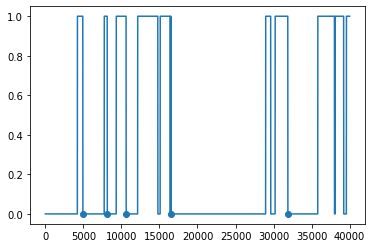

In [270]:
plt.plot(h[:2*20000])
plt.scatter(idx_down_h_50[idx_down_h_50<2*20000],h[:2*20000][idx_down_h_50[idx_down_h_50<2*20000]])


In [348]:
Is_up_50 = []
frs_up_50 = []
Is_down_50 = []
frs_down_50 = []

for i in idx_up_h_50:
    Is_up_50.append(I[i:i+50*20])
for i in idx_down_h_50:
    Is_down_50.append(I[i:i+50*20])


for j in range(len(fr_convs_gaussian)):
    frs_up_temp =[]
    frs_down_temp =[]
    for i in idx_up_h_50:
        frs_up_temp.append(np.hstack(fr_convs_gaussian[j][i:i+50*20]))
    frs_up_50.append(frs_up_temp)
    for i in idx_down_h_50:
        frs_down_temp.append(np.hstack(fr_convs_gaussian[j][i:i+50*20]))
    frs_down_50.append(frs_down_temp)


Is_up_100 = []
frs_up_100 = []
Is_down_100 = []
frs_down_100 = []
for i in idx_up_h_100:
    Is_up_100.append(I[i:i+100*20])
for i in idx_down_h_100:
    Is_down_100.append(I[i:i+100*20])


for j in range(len(fr_convs_gaussian)):
    frs_up_temp =[]
    frs_down_temp =[]
    for i in idx_up_h_100:
        frs_up_temp.append(np.hstack(fr_convs_gaussian[j][i:i+100*20]))
    frs_up_100.append(frs_up_temp)
    for i in idx_down_h_100:
        frs_down_temp.append(np.hstack(fr_convs_gaussian[j][i:i+100*20]))
    frs_down_100.append(frs_down_temp)


Is_up_500 = []
frs_up_500 = []
Is_down_500 = []
frs_down_500 = []
for i in idx_up_h_500:
    Is_up_500.append(I[i:i+500*20])
for i in idx_down_h_500:
    Is_down_500.append(I[i:i+500*20])


for j in range(len(fr_convs_gaussian)):
    frs_up_temp =[]
    frs_down_temp =[]
    for i in idx_up_h_500:
        frs_up_temp.append(np.hstack(fr_convs_gaussian[j][i:i+500*20]))
    frs_up_500.append(frs_up_temp)
    for i in idx_down_h_500:
        frs_down_temp.append(np.hstack(fr_convs_gaussian[j][i:i+500*20]))
    frs_down_500.append(frs_down_temp)






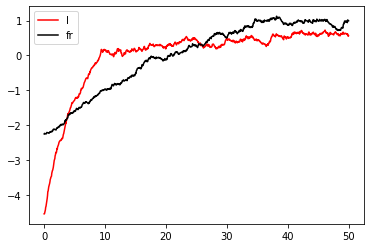

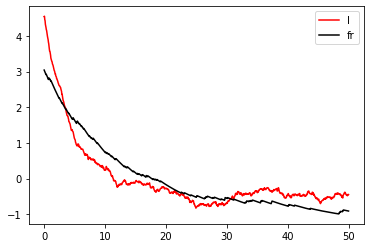

In [349]:
def STA(data):
    return np.mean(np.array(data),axis=0)
x = np.linspace(0,50,50*20)

plt.plot(x,standardize(np.mean(np.array(Is_up_50),axis=0)),c='r')
plt.plot(x,standardize(np.mean(np.array(frs_up_50[0]),axis=0)),c='black')
plt.legend(['I','fr'])
plt.show()
plt.plot(x,standardize(np.mean(np.array(Is_down_50),axis=0)),c='r')
plt.plot(x,standardize(np.mean(np.array(frs_down_50[0]),axis=0)),c='black')
plt.legend(['I','fr'])
plt.show()

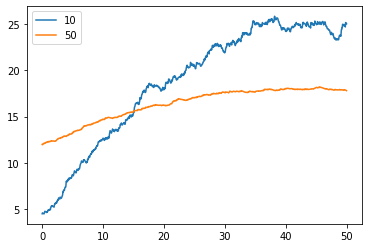

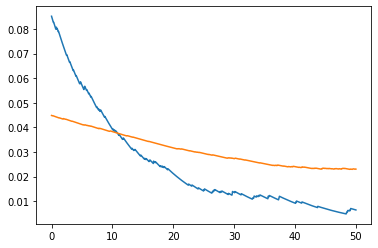

In [350]:
x = np.linspace(0,50,50*20)
for i in range(len(frs_up_50[:2])):
    plt.plot(x,STA(frs_up_50[i]))
plt.legend([10,50,100])
plt.show()
for i in range(len(frs_down_50[:2])):
    plt.plot(x,STA(frs_down_50[i])/np.linalg.norm(STA(frs_down_50[i])))
plt.show()




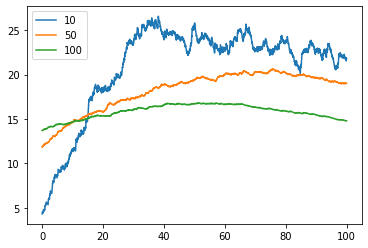

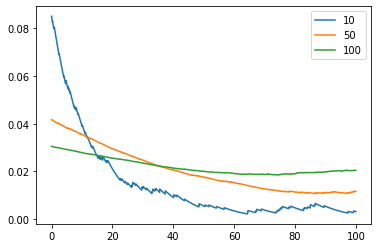

In [351]:
x = np.linspace(0,100,100*20)

for i in range(len(frs_up_100[:3])):
    plt.plot(x,STA(frs_up_100[i]))
plt.legend([10,50,100])
plt.show()
for i in range(len(frs_down_100[:3])):
    plt.plot(x, STA(frs_down_100[i])/np.linalg.norm(STA(frs_down_100[i])))
    plt.legend([10,50,100])
plt.show()




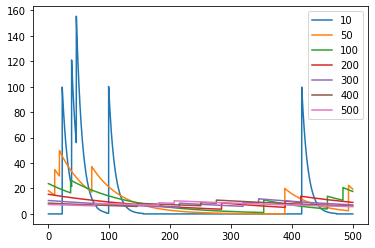

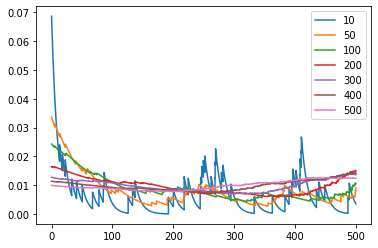

In [352]:
x = np.linspace(0,500,500*20)

for i in range(len(frs_up_500)):
    plt.plot(x,STA(frs_up_500[i]))
plt.legend([10,50,100,200,300,400,500])
plt.show()

for i in range(len(frs_down_500)):
    plt.plot(x, STA(frs_down_500[i])/np.linalg.norm(STA(frs_down_500[i])))
plt.legend([10,50,100,200,300,400,500])
plt.show()




In [380]:

idx_up_h_50_first = idx_up_h_50[idx_up_h_50<180*20000]
idx_up_h_50_second = idx_up_h_50[idx_up_h_50>180*20000]

idx_down_h_50_first = idx_down_h_50[idx_down_h_50<180*20000]
idx_down_h_50_second = idx_down_h_50[idx_down_h_50>180*20000]

idx_up_h_100_first = idx_up_h_100[idx_up_h_100<180*20000]
idx_up_h_100_second = idx_up_h_100[idx_up_h_100>180*20000]

idx_down_h_100_first = idx_down_h_100[idx_down_h_100<180*20000]
idx_down_h_100_second = idx_down_h_100[idx_down_h_100>180*20000]


def return_frs(idx_up,idx_down,frs,I,time):
    Is_up = []
    frs_up = []
    Is_down = []
    frs_down = []

    for i in idx_up:
        Is_up.append(I[i:i+time*20])
    for i in idx_down:
        Is_down.append(I[i:i+time*20])


    for j in range(len(frs)):
        frs_up_temp =[]
        frs_down_temp =[]
        for i in idx_up:
            frs_up_temp.append(np.hstack(frs[j][i:i+time*20]))
        frs_up.append(frs_up_temp)
        for i in idx_down:
            frs_down_temp.append(np.hstack(frs[j][i:i+time*20]))
        frs_down.append(frs_down_temp)
    return Is_up,frs_up,Is_down,frs_down

Is_up_first,frs_up_first,Is_down_first,frs_down_first = return_frs(idx_up_h_50_first,idx_down_h_50_first,fr_convs_exps,I,50)
Is_up_second,frs_up_second,Is_down_second,frs_down_second = return_frs(idx_up_h_50_second,idx_down_h_50_second,fr_convs_exps,I,50)


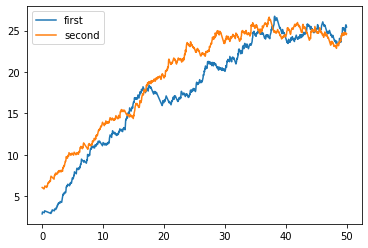

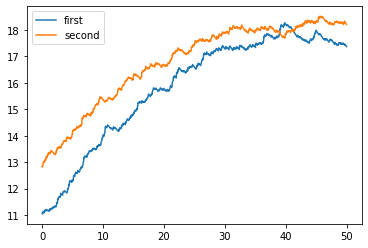

In [377]:
x = np.linspace(0,50,50*20)
plt.plot(x,STA(frs_up_first[0]))
plt.plot(x,STA(frs_up_second[0]))
plt.legend(['first','second'])
plt.show()

plt.plot(x,STA(frs_up_first[1]))
plt.plot(x,STA(frs_up_second[1]))
plt.legend(['first','second'])
plt.show()



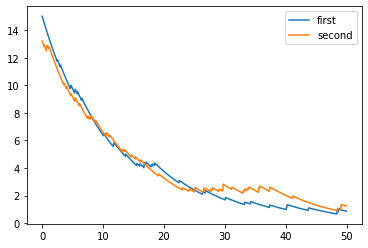

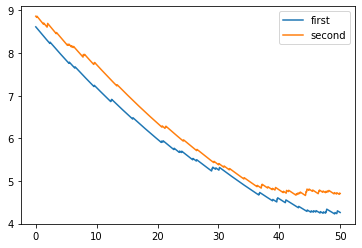

In [378]:
x = np.linspace(0,50,50*20)
plt.plot(x,STA(frs_down_first[0]))
plt.plot(x,STA(frs_down_second[0]))
plt.legend(['first','second'])
plt.show()

plt.plot(x,STA(frs_down_first[1]))
plt.plot(x,STA(frs_down_second[1]))
plt.legend(['first','second'])
plt.show()


In [381]:

Is_up_first,frs_up_first,Is_down_first,frs_down_first = return_frs(idx_up_h_100_first,idx_down_h_100_first,fr_convs_exps,I,100)
Is_up_second,frs_up_second,Is_down_second,frs_down_second = return_frs(idx_up_h_100_second,idx_down_h_100_second,fr_convs_exps,I,100)


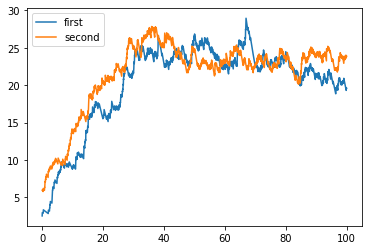

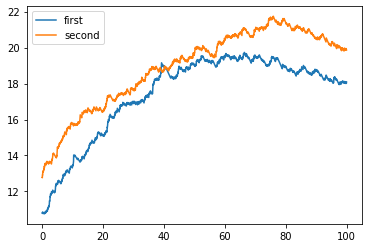

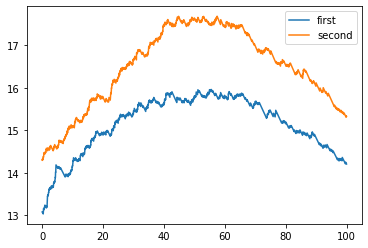

In [385]:
x = np.linspace(0,100,100*20)
plt.plot(x,STA(frs_up_first[0]))
plt.plot(x,STA(frs_up_second[0]))
plt.legend(['first','second'])
plt.show()

plt.plot(x,STA(frs_up_first[1]))
plt.plot(x,STA(frs_up_second[1]))
plt.legend(['first','second'])
plt.show()

plt.plot(x,STA(frs_up_first[2]))
plt.plot(x,STA(frs_up_second[2]))
plt.legend(['first','second'])
plt.show()

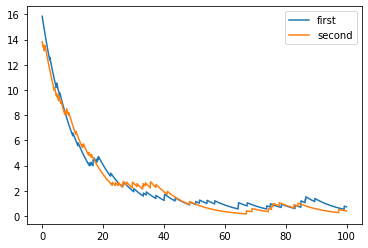

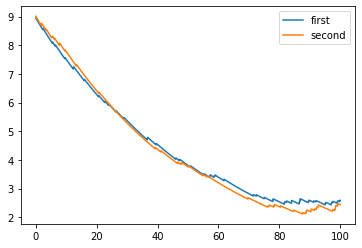

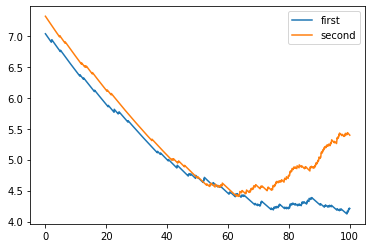

In [384]:
x = np.linspace(0,100,100*20)
plt.plot(x,STA(frs_down_first[0]))
plt.plot(x,STA(frs_down_second[0]))
plt.legend(['first','second'])
plt.show()

plt.plot(x,STA(frs_down_first[1]))
plt.plot(x,STA(frs_down_second[1]))
plt.legend(['first','second'])
plt.show()


plt.plot(x,STA(frs_down_first[2]))
plt.plot(x,STA(frs_down_second[2]))
plt.legend(['first','second'])
plt.show()
